# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython import display

# Parameters

In [ ]:
BATCH_SIZE=128
LATENT_DIM=2

# Providing the Data

In [ ]:
def map_image(image, label):
  '''Returns a normalized and reshaped tensor from a given image'''
  image = tf.cast(image, dtype=tf.float32)
  image /= 255.0
  image = tf.reshape(image, shape=(28,28,1,))
  return image

def get_dataset(map_fn, is_validation=False):
  '''Loads and prepares the mnist dataset from TFDS'''
  if is_validation:
    split_name = "test"
  else:
    split_name = "train"
  
  dataset = tfds.load("mnist", as_supervised=True, split=split_name)
  dataset = dataset.map(map_fn)

  if is_validation:
    dataset = dataset.batch(BATCH_SIZE)
  else:
    dataset = dataset.shuffle(1024).batch(BATCH_SIZE)
  
  return dataset

In [ ]:
train_dataset = get_dataset(map_image)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Encoder

In [ ]:
def encoder_layers(inputs, latent_dim):
  x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu", name="encode_conv1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu", name="encoder_conv2")(x)

  batch_2 = tf.keras.layers.BatchNormalization()(x)


  x = tf.keras.layers.Flatten(name="encode_flatten")(batch_2)

  x = tf.keras.layers.Dense(20, activation="relu", name="encoder_dense")(x)
  x = tf.keras.layers.BatchNormalization()(x)

  mu = tf.keras.layers.Dense(latent_dim, name="latent_mu")(x)
  sigma = tf.keras.layers.Dense(latent_dim, name="latent_sigma")(x)

  return mu, sigma, batch_2.shape

In [ ]:
class Sampling(tf.keras.layers.Layer):
  def call(self, inputs):
    mu, sigma = inputs

    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]

    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

    return mu + tf.exp(0.5 * sigma) * epsilon

In [ ]:
def encoder_model(latent_dim, input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)

  mu, sigma, conv_shape = encoder_layers(inputs, latent_dim=LATENT_DIM)

  z = Sampling()((mu, sigma))

  model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma, z])

  return model, conv_shape

# Decoder

In [ ]:
def decoder_layers(inputs, conv_shape):
  units = conv_shape[1] * conv_shape[2] * conv_shape[3]
  x = tf.keras.layers.Dense(units, activation='relu',
                            name="decode_dense1")(inputs)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]),
                              name="decode_reshape")(x)
  x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2,
                                      padding='same', activation='relu',
                                      name='decode_conv2d_2')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2,
                                      padding='same', activation='relu',
                                      name='decode_conv2d_3')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1,
                                      padding='same', activation='sigmoid',
                                      name='decode_final')(x)

  return x

In [ ]:
def decoder_model(latent_dim, conv_shape):
  inputs = tf.keras.layers.Input(shape=(latent_dim,))
  outputs = decoder_layers(inputs, conv_shape)
  model = tf.keras.Model(inputs, outputs)
  return model

# KL Reconstruction Loss

In [ ]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
  kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
  return tf.reduce_mean(kl_loss) * -0.5

# VAE Model

In [ ]:
def vae_model(encoder, decoder, input_shape):
  inputs = tf.keras.layers.Input(shape=input_shape)
  mu = encoder(inputs)[0]
  sigma = encoder(inputs)[1]
  z = encoder(inputs)[2]
  reconstructed = decoder(z)
  model = tf.keras.Model(inputs=inputs, outputs=reconstructed)
  loss = kl_reconstruction_loss(inputs, z, mu, sigma)
  model.add_loss(loss)
  return model

In [ ]:
def get_models(input_shape, latent_dim):
  """Returns the encoder, decoder, and vae models"""
  encoder, conv_shape = encoder_model(latent_dim=latent_dim, input_shape=input_shape)
  decoder = decoder_model(latent_dim=latent_dim, conv_shape=conv_shape)
  vae = vae_model(encoder, decoder, input_shape=input_shape)
  return encoder, decoder, vae

In [ ]:
# Get the encoder, decoder and 'master' model (called vae)
encoder, decoder, vae = get_models(input_shape=(28,28,1,), latent_dim=LATENT_DIM)

# Train the Model

In [ ]:
# Define our loss functions and optimizers
optimizer = tf.keras.optimizers.Adam()
loss_metric = tf.keras.metrics.Mean()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def generate_and_save_images(model, epoch, step, test_input):
  """Helper function to plot our 16 images

  Args:

  model -- the decoder model
  epoch -- current epoch number during training
  step -- current step number during training
  test_input -- random tensor with shape (16, LATENT_DIM)
  """

  # generate images from the test input
  predictions = model.predict(test_input)

  # plot the results
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  fig.suptitle("epoch: {}, step: {}".format(epoch, step))
  plt.savefig('image_at_epoch_{:04d}_step{:04d}.png'.format(epoch, step))
  plt.show()

1/1 [==============================] - 0s 15ms/step


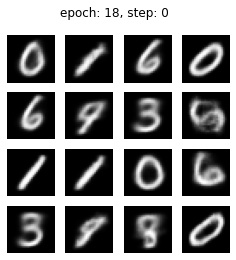

Epoch: 18 step: 0 mean loss = 154.61256


In [ ]:
# Training loop

# generate random vector as test input to the decoder
random_vector_for_generation = tf.random.normal(shape=[16, LATENT_DIM])

# number of epochs
epochs = 100

# initialize the helper function to display outputs from an untrained model
generate_and_save_images(decoder, 0, 0, random_vector_for_generation)

for epoch in range(epochs):
  print('Start of epoch %d' % (epoch, ))

  # iterate over the batches of the dataset
  for step, x_batch_train in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      # feed a batch to the VAE model
      reconstructed = vae(x_batch_train)

      # compute reconstruction loss
      flattened_inputs = tf.reshape(x_batch_train, shape=[-1])
      flattened_outputs = tf.reshape(reconstructed, shape=[-1])
      loss = bce_loss(flattened_inputs, flattened_outputs) * 784  # image size (28 * 28 * 1)
      
      # add KLD regularization loss
      loss += sum(vae.losses)

    # get the gradients and update the weights
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))

    # compute the loss metric
    loss_metric(loss)

    # display outputs every 100 steps
    if step % 100 == 0:
      display.clear_output(wait=False)
      generate_and_save_images(decoder, epoch, step, random_vector_for_generation)
      print('Epoch: %s step: %s mean loss = %s' % (epoch, step, loss_metric.result().numpy()))